# Dealiasing the data
- **Note** : The data should be periodic in x and y domain

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.io import loadmat

from py2d.initialize import initialize_wavenumbers_2DFHIT, gridgen
from py2d.dealias import multiply_dealias
from py2d.convert import Omega2Psi_2DFHIT
from py2d.filter import filter2D_2DFHIT

# Define the analytical function
def analytical_function(x, y):
    return np.sin(100*x), np.cos(y)

def multiply_analytical_function(x, y):
    # This is simplified expression after multiplying the above two analystical functions
    return 0.5 * (np.sin(100*x+y) + np.sin(100*x-y))

# Define the domain size and number of grid points
Lx, Ly = 2*np.pi, 2*np.pi # Domain size
Nx, Ny = 1024, 1024 # Number of grid points

# Generate grid with given domain size and number of grid points
Lx, Ly, X, Y, dx, dy = gridgen(Lx, Ly, Nx, Ny, INDEXING='ij')

# Initialize wavenumbers for 2D Fourier-based pseudo-spectral differentiation
Kx, Ky, Kabs, Ksq, invKsq = initialize_wavenumbers_2DFHIT(Nx, Ny, Lx, Ly, INDEXING='ij')

In [2]:
# Compute the analytical function on the grid

# Define parameters 
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'

# Load the data from the file
data = loadmat(filename)
# Extract the Omega data from the file
Omega_DNS = data['Omega']
Psi_DNS = Omega2Psi_2DFHIT(Omega_DNS, invKsq=invKsq)

fa, fb = analytical_function(X, Y)
fab = multiply_analytical_function(X, Y)
fa_DNS = Omega_DNS
fb_DNS = Psi_DNS
fab_DNS = fa_DNS*fb_DNS

fab = filter2D_2DFHIT(fab_DNS, filterType=None, coarseGrainType='spectral', Ngrid=[Nx,Ny])

fa = filter2D_2DFHIT(fa_DNS, filterType=None, coarseGrainType='spectral', Ngrid=[Nx,Ny])
fb = filter2D_2DFHIT(fb_DNS, filterType=None, coarseGrainType='spectral', Ngrid=[Nx,Ny])

fab_dealiased = multiply_dealias(fa, fb, dealias=True)

fab_aliased = multiply_dealias(fa, fb, dealias=False)
fab_aliased2 = fa*fb

# Calculate MSE and correlation for dealiased version
mse_dealiased = mean_squared_error(fab.flatten(), fab_dealiased.flatten())
corr_dealiased, _ = pearsonr(fab.flatten(), fab_dealiased.flatten())

# Calculate MSE and correlation for aliased version
mse_aliased = mean_squared_error(fab.flatten(), fab_aliased.flatten())
corr_aliased, _ = pearsonr(fab.flatten(), fab_aliased.flatten())

# Print MSE and correlation coefficients
print(f"MSE (Aliased): {mse_aliased}, Correlation coefficient (Aliased): {corr_aliased}")
print(f"MSE (Dealiased): {mse_dealiased}, Correlation coefficient (Dealiased): {corr_dealiased}")



MSE (Aliased): 5.9056809507291396e-30, Correlation coefficient (Aliased): 0.9999999999999959
MSE (Dealiased): 5.297238427745156e-07, Correlation coefficient (Dealiased): 0.9999999887713718


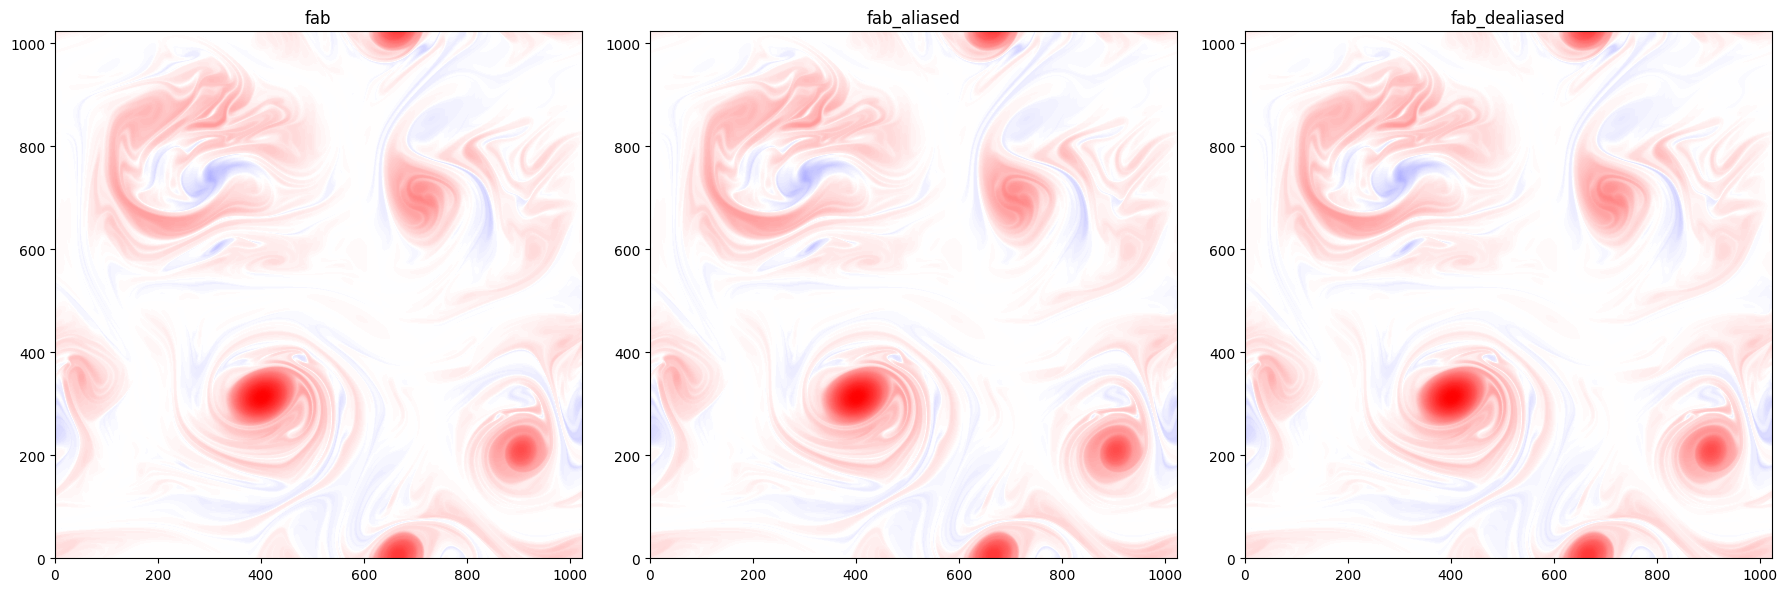

In [3]:

# Setting up the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Common colormap and normalization
cmap = 'bwr'

vmax = np.max(fab)
vmin = -vmax


# Normalization
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Plotting fab
contour1 = ax[0].contourf(fab, cmap=cmap, levels=100, vmax=vmax, vmin=vmin)
ax[0].set_title('fab')
ax[0].set_aspect('equal')

# Plotting fab_dealiased
contour2 = ax[1].contourf(fab_aliased, cmap=cmap, levels=100, vmax=vmax, vmin=vmin)
ax[1].set_title('fab_aliased')
ax[1].set_aspect('equal')

# Plotting fab_aliased
contour3 = ax[2].contourf(fab_dealiased, cmap=cmap, levels=100, vmax=vmax, vmin=vmin)
ax[2].set_title('fab_dealiased')
ax[2].set_aspect('equal')


plt.tight_layout()
plt.show()


Testing the dealiasing Code by comparing the norm of the SGS before and after dealising
Dealising should remove errors at high wavenumbers hence reducing the norm

Testing for accuracy of SGS Decomposition Code. The sum of Leonard, Cross, and Reynolds should be equal to SGS term


/var/folders/x6/fx3v22fd3h33fqnrs23l8_sh0000gn/T/ipykernel_33640/2071200931.py:47: UserWarning: The following kwargs were not used by contour: 'llevels'
  axs[0, 3].contourf(Tau12Reynolds, llevels=200, cmap='bwr', vmin=vmin, vmax=vmax)
/var/folders/x6/fx3v22fd3h33fqnrs23l8_sh0000gn/T/ipykernel_33640/2071200931.py:52: UserWarning: The following kwargs were not used by contour: 'llevels'
  axs[1, 2].contourf(Tau12Cross_dealiased, llevels=200, cmap='bwr', vmin=vmin, vmax=vmax)


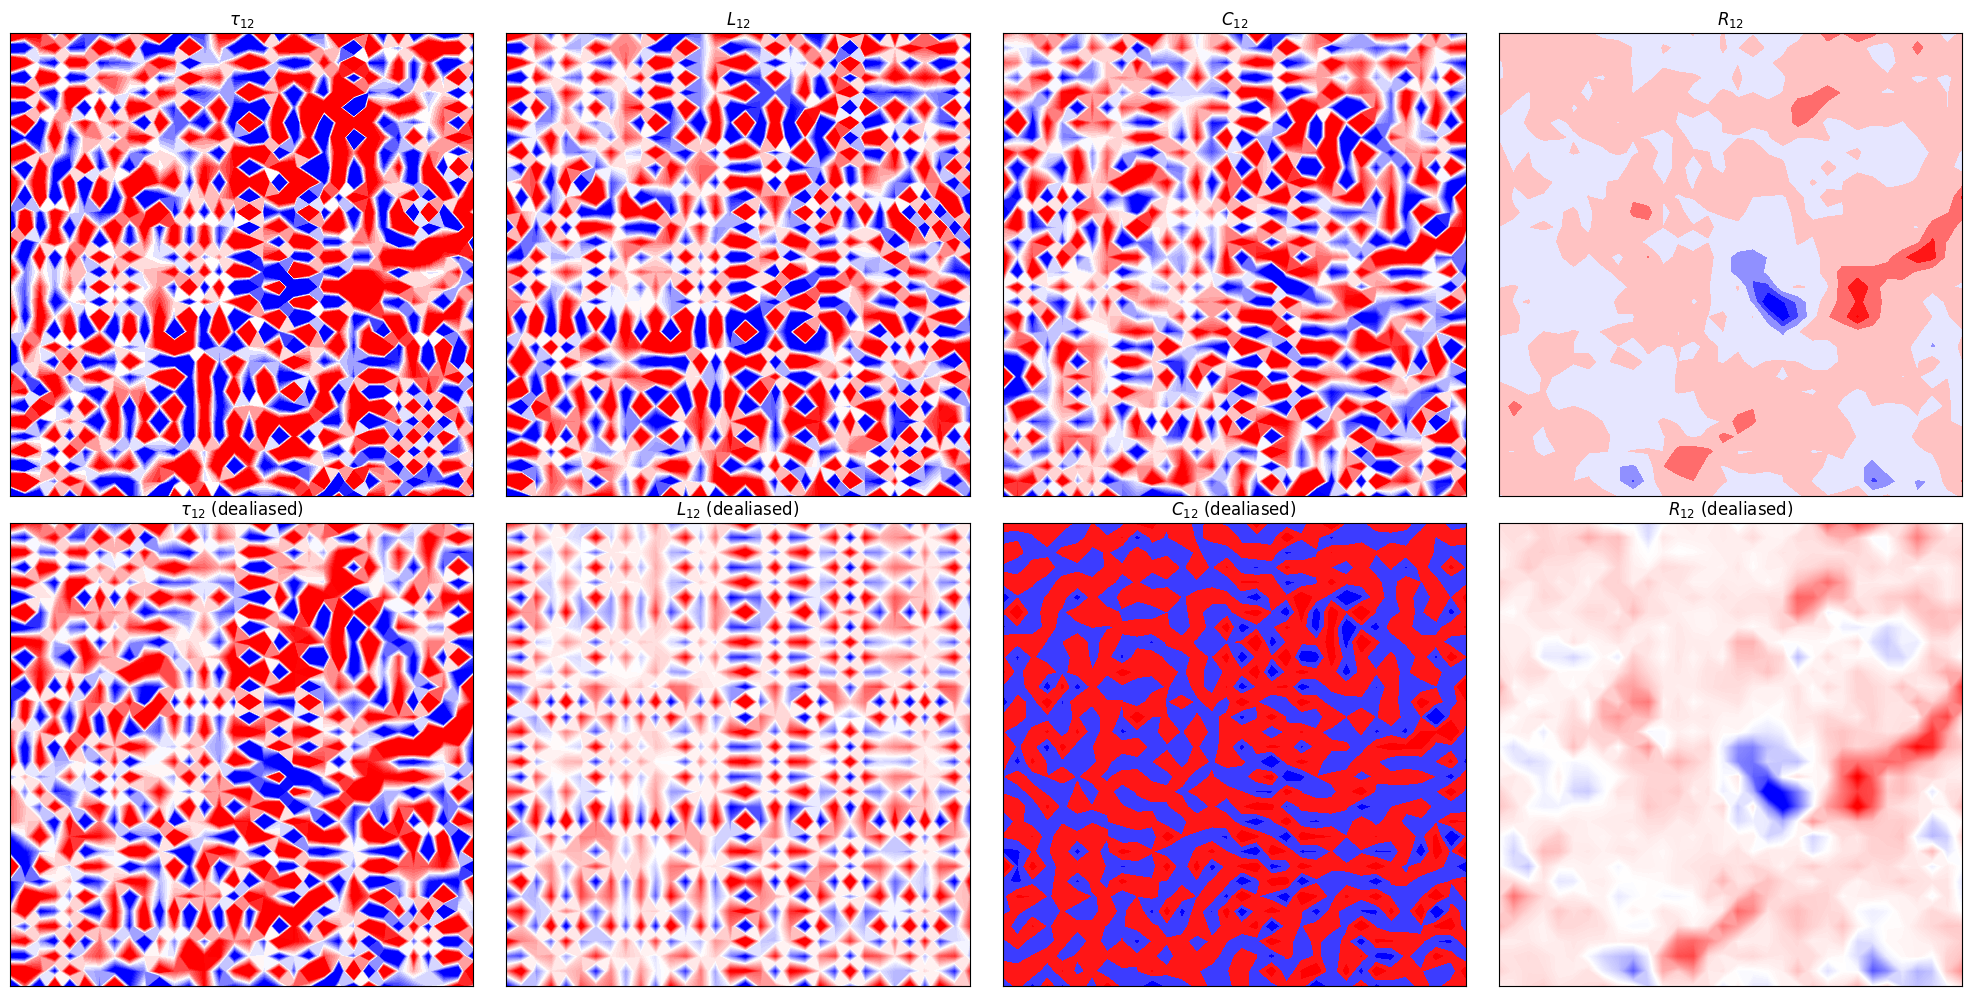

Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 2.154482417814167 1.7990767104057783 1.1427760844008688 0.10572447118238346
DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 1.3662671 0.7269992 1.1427758 0.10572445
##########################################################


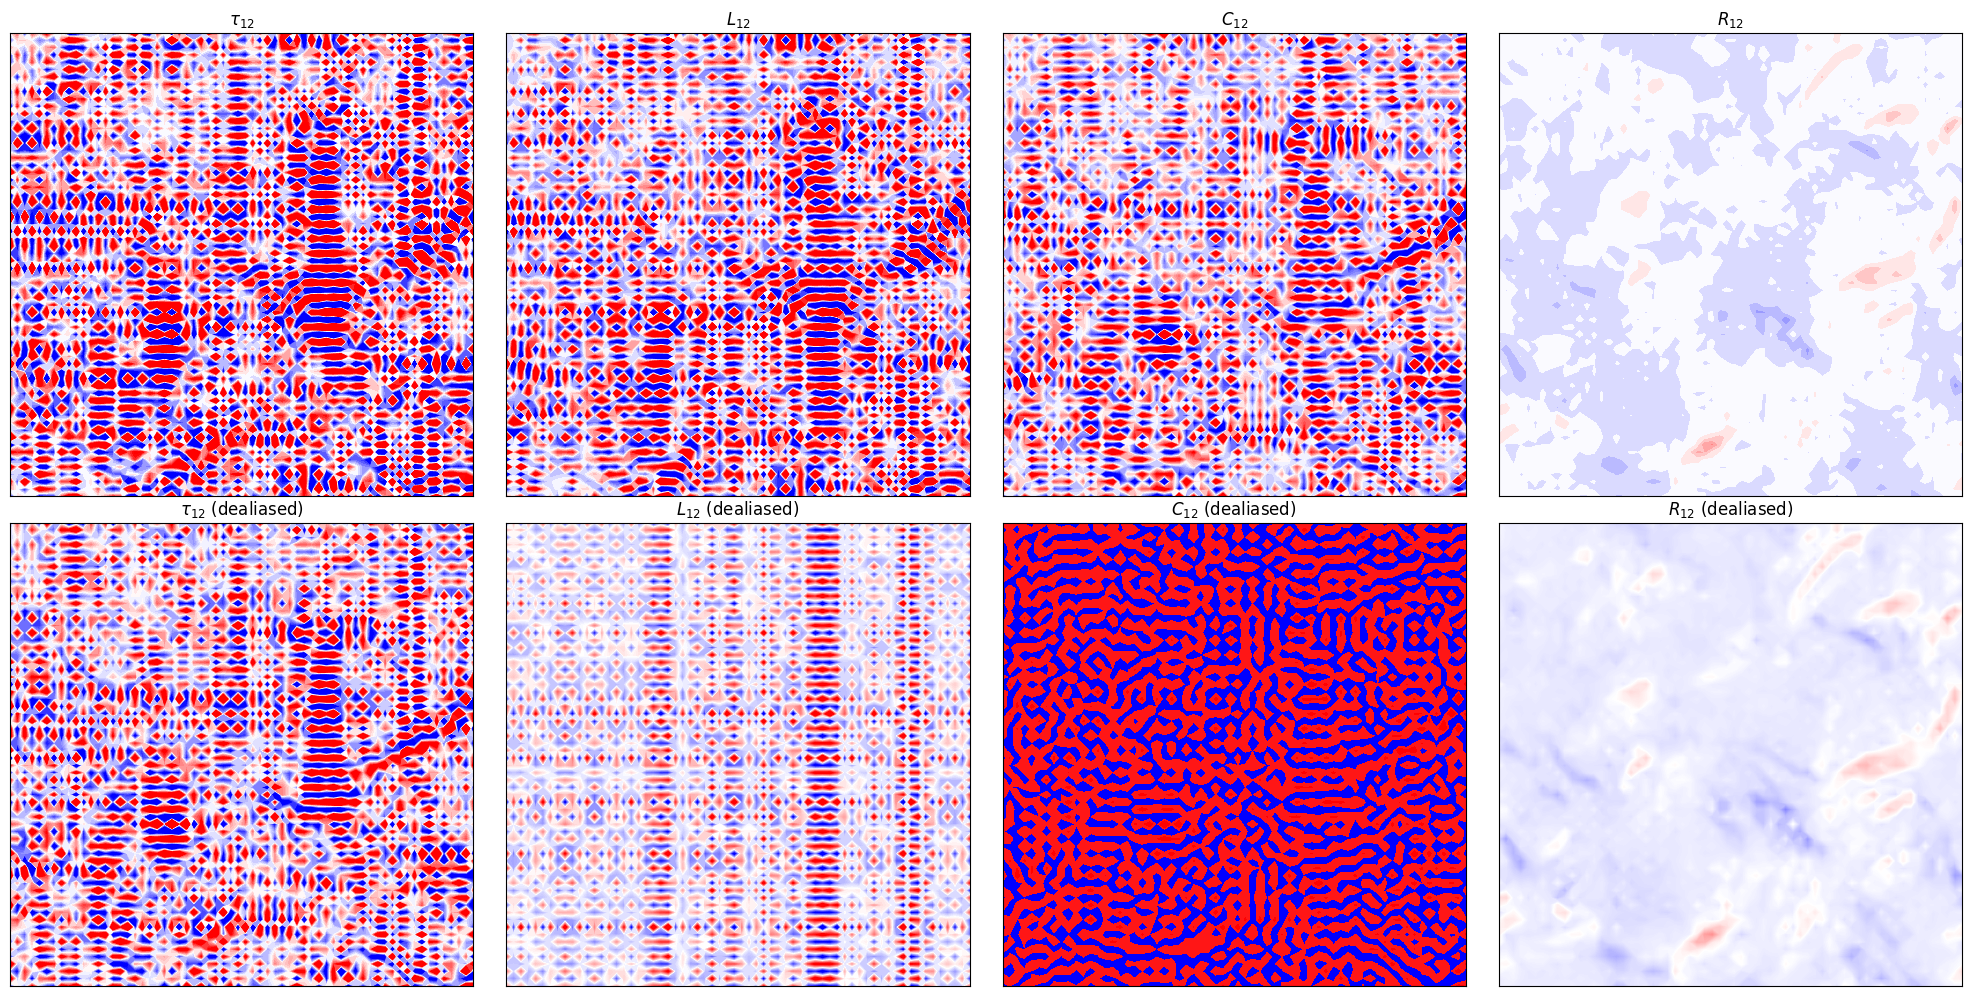

Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 0.9392029575201354 0.7756526552485843 0.5223671970419426 0.026674785638568486
DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 0.5916409 0.27404395 0.5223671 0.02667478
##########################################################


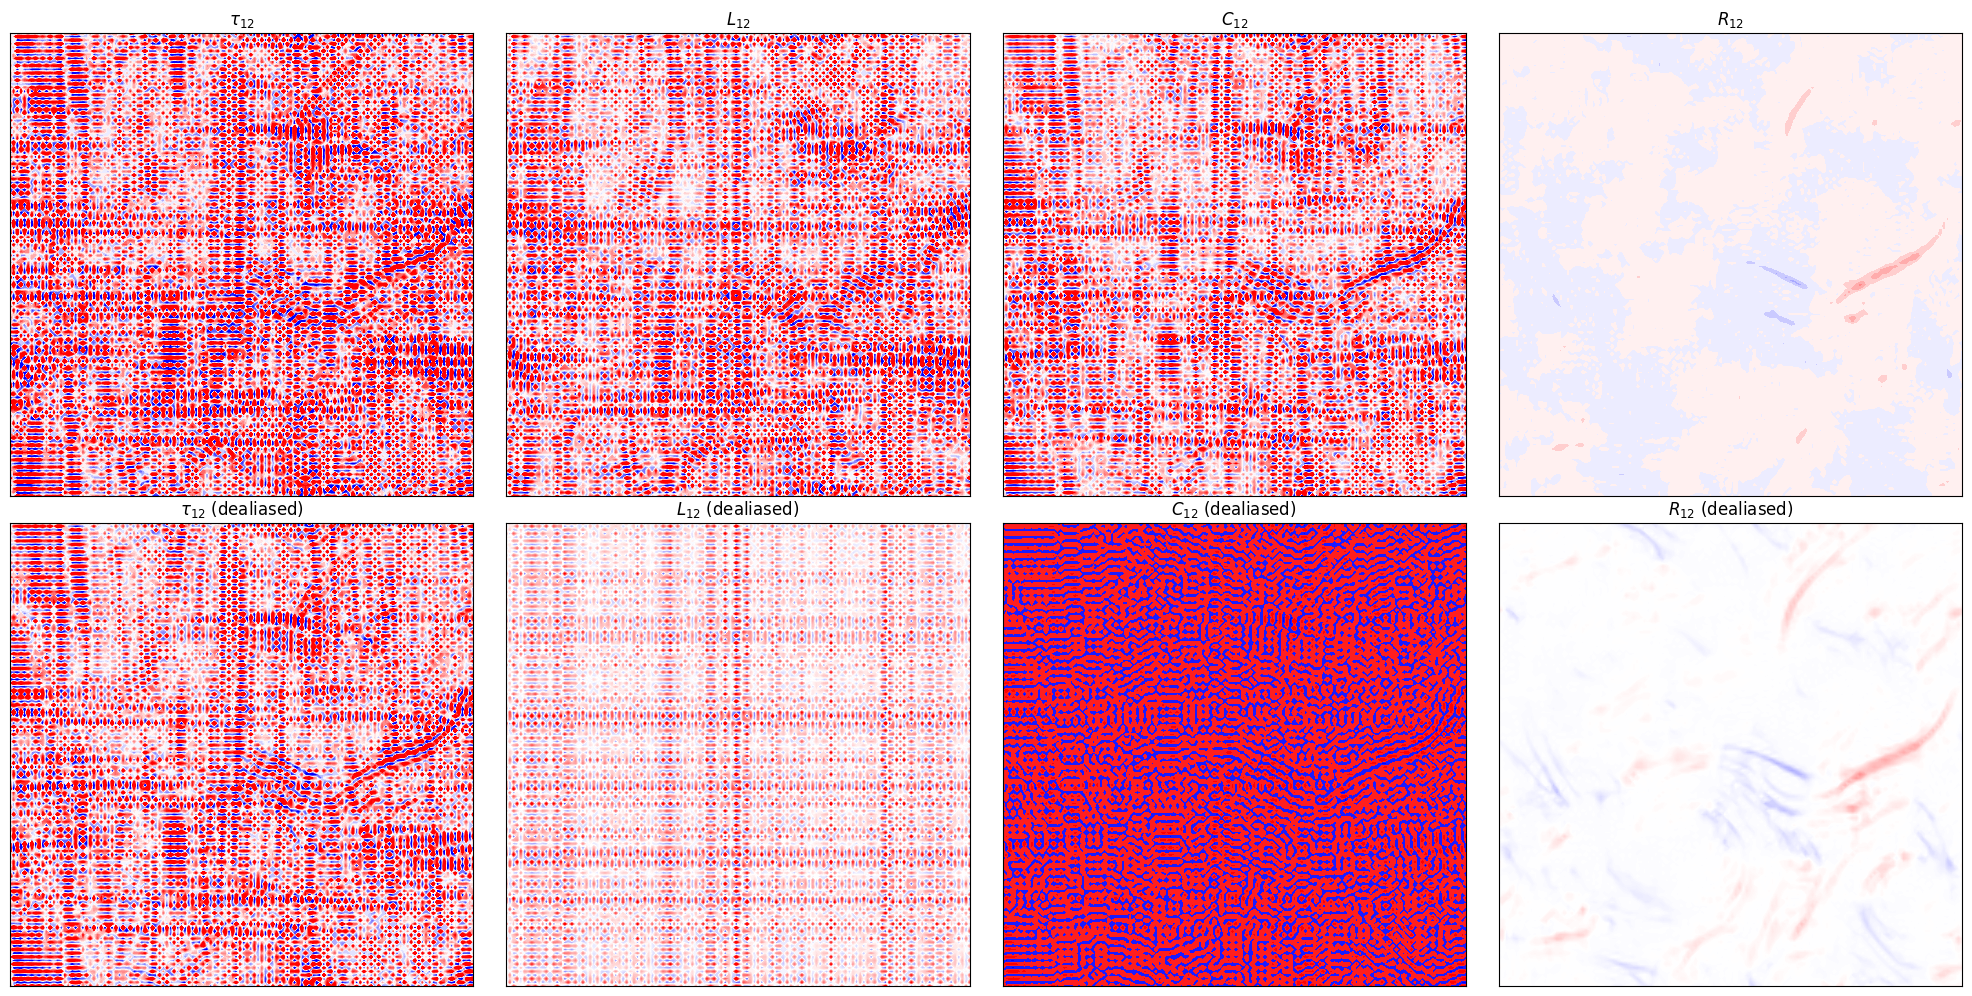

Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 0.4581917067826303 0.34994435658943995 0.27573628220184904 0.008367006386247624
DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 0.29523426 0.1047584 0.2757362 0.008367005
##########################################################


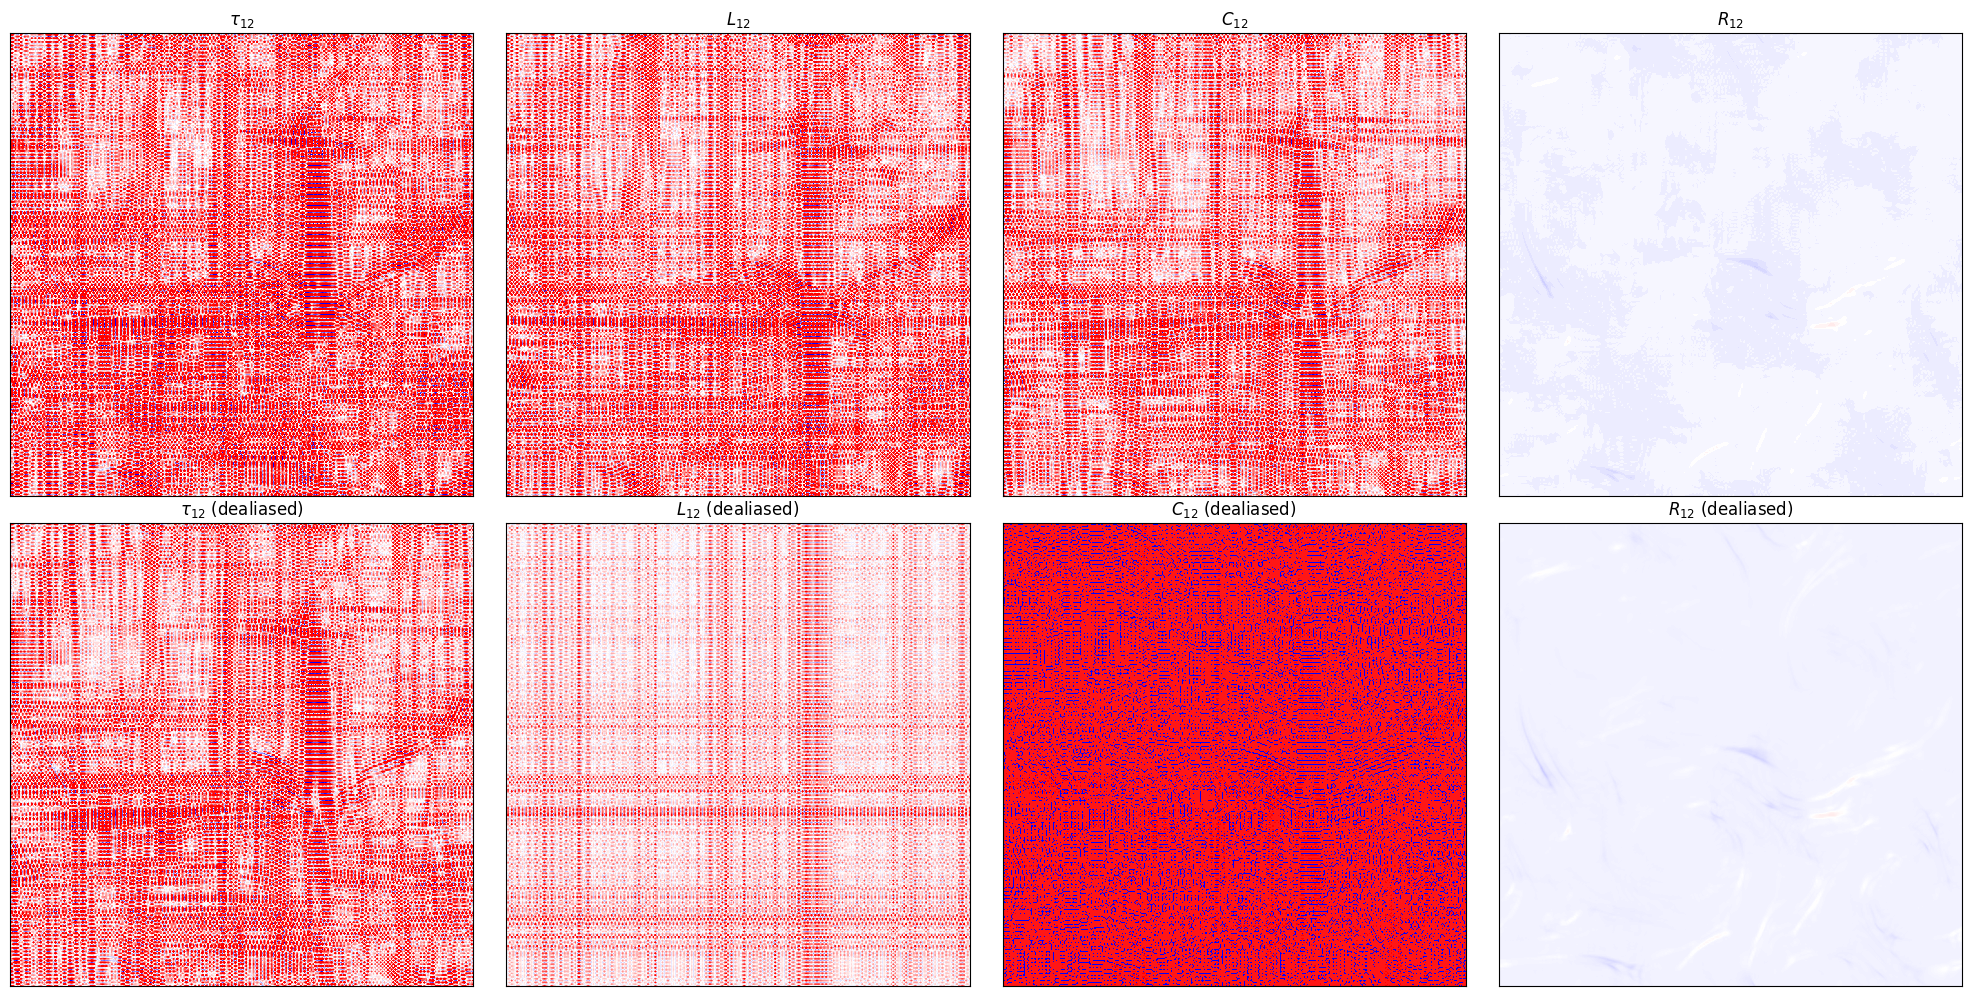

Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 0.19778220370190377 0.1481629246192764 0.124195064341363 0.001296130429991876
DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds 0.1329819 0.0474962 0.12419504 0.001296145
##########################################################


In [4]:
from py2d.SGSterms import TauLeonard, TauCross, TauReynolds, Tau

# Following code tests the accurancy of the SGS decomposition code by ensuring that the sum of Leonard, Cross, and Reynolds is equal to SGS term
print("Testing for accuracy of SGS Decomposition Code. The sum of Leonard, Cross, and Reynolds should be equal to SGS term")

# Initialize filter and coarse grain types for SGS terms calculation
filterType = 'spectral-square'
coarseGrainType = 'spectral'

# Loop over different grid sizes to test the accuracy of SGS decomposition
for k in [32, 64, 128, 256]:

    # Calculate the LES grid size and filter width (Delta)
    N_LES = np.array([k, k])
    Delta = 2 * Lx / N_LES[0]  # Assuming Lx is defined elsewhere as the domain size

    # Compute the SGS terms without and with dealiasing
    Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
    Tau11_dealiased, Tau12_dealiased, Tau22_dealiased = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

    # Compute individual SGS terms (Leonard, Cross, Reynolds) without and with dealiasing
    Tau11Leonard, Tau12Leonard, Tau22Leonard = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
    Tau11Leonard_dealiased, Tau12Leonard_dealiased, Tau22Leonard_dealiased = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

    Tau11Cross, Tau12Cross, Tau22Cross = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
    Tau11Cross_dealiased, Tau12Cross_dealiased, Tau22Cross_dealiased = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

    Tau11Reynolds, Tau12Reynolds, Tau22Reynolds = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=False)
    Tau11Reynolds_dealiased, Tau12Reynolds_dealiased, Tau22Reynolds_dealiased = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=True)

    # Plot contours of all computed SGS terms
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    # Determine common limits for color scaling
    vmin = 0.1*min(Tau12.min(), Tau12Leonard.min(), Tau12Cross.min(), Tau12Reynolds.min(), 
            Tau12_dealiased.min(), Tau12Leonard_dealiased.min(), Tau12Cross_dealiased.min(), Tau12Reynolds_dealiased.min())
    vmax = 0.1*max(Tau12.max(), Tau12Leonard.max(), Tau12Cross.max(), Tau12Reynolds.max(), 
            Tau12_dealiased.max(), Tau12Leonard_dealiased.max(), Tau12Cross_dealiased.max(), Tau12Reynolds_dealiased.max())

    # Titles for each subplot
    titles = ['$\\tau_{12}$', '$L_{12}$', '$C_{12}$', '$R_{12}$', '$\\tau_{12}$ (dealiased)', '$L_{12}$ (dealiased)', '$C_{12}$ (dealiased)', '$R_{12}$ (dealiased)']

    # First row - non-dealiased terms
    axs[0, 0].contourf(Tau12, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
    axs[0, 1].contourf(Tau12Leonard, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
    axs[0, 2].contourf(Tau12Cross, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
    axs[0, 3].contourf(Tau12Reynolds, llevels=200, cmap='bwr', vmin=vmin, vmax=vmax)

    # Second row - dealiased terms
    axs[1, 0].contourf(Tau12_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
    axs[1, 1].contourf(Tau12Leonard_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)
    axs[1, 2].contourf(Tau12Cross_dealiased, llevels=200, cmap='bwr', vmin=vmin, vmax=vmax)
    axs[1, 3].contourf(Tau12Reynolds_dealiased, levels=200, cmap='bwr', vmin=vmin, vmax=vmax)

    # Set titles and make layout adjustments
    for ax, title in zip(axs.flat, titles ):
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    # Calculate the norm of the SGS terms
    norm_Tau11 = np.linalg.norm(Tau11.flatten())
    norm_Tau11Leonard = np.linalg.norm(Tau11Leonard.flatten())
    norm_Tau11Cross = np.linalg.norm(Tau11Cross.flatten())
    norm_Tau11Reynolds = np.linalg.norm(Tau11Reynolds.flatten())

    norm_Tau11_dealiased = np.linalg.norm(Tau11_dealiased.flatten())
    norm_Tau11Leonard_dealiased = np.linalg.norm(Tau11Leonard_dealiased.flatten())
    norm_Tau11Cross_dealiased = np.linalg.norm(Tau11Cross_dealiased.flatten())
    norm_Tau11Reynolds_dealiased = np.linalg.norm(Tau11Reynolds_dealiased.flatten())

    print("Aliased   norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds", norm_Tau11, norm_Tau11Leonard, norm_Tau11Cross, norm_Tau11Reynolds) 
    print("DeAliased norm Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds", norm_Tau11_dealiased, norm_Tau11Leonard_dealiased, norm_Tau11Cross_dealiased, norm_Tau11Reynolds_dealiased)
    print("##########################################################")
